In [1]:
% matplotlib inline
import os
import numpy as np
import nibabel as nib
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
import nipy.algorithms.statistics.rft as rft
from __future__ import print_function, division
import math
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb
from nipype.interfaces import fsl
import pandas as pd
import nipy.algorithms.statistics.intvol as intvol
from matplotlib import colors
import scipy.stats as stats

import statsmodels.sandbox.stats.multicomp as multicomp

In [2]:
def nulprobdensRFT(exc,peaks):
    f0 = exc*np.exp(-exc*(peaks-exc))
    return f0

In [3]:
thres = [0.01,0.02,0.03,0.04,0.05]
res = {}
means = []
exc = 3

for alphval in thres:
    print(alphval)
    hatFDR = []
    for k in range(1000):
        smooth_FWHM = 3
        smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
        data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(50,50,50),noise_level=1)
        data[0:25,0:25,0:25] = data[0:25,0:25,0:25]+2.5
        img=nib.Nifti1Image(data,np.eye(4))
        img.to_filename("files/RF.nii.gz")

        cl=fsl.model.Cluster()
        cl.inputs.threshold = exc
        cl.inputs.in_file="files/RF.nii.gz"
        cl.inputs.out_localmax_txt_file="files/locmax.txt"
        cl.inputs.num_maxima=1000000
        cl.inputs.connectivity=26
        cl.inputs.terminal_output='none'
        cl.run()

        peaks = pd.read_csv("files/locmax.txt",sep="\t").drop('Unnamed: 5',1)
        peaks.Value = peaks.Value

        peaks['Pvals'] = nulprobdensRFT(exc,peaks.Value)
        
        psorted = np.sort(peaks.Pvals)
        qsorted = (np.array(range(len(psorted)))/len(psorted))*alphval
        pr = [1 if a<b else 0 for a,b in zip(psorted,qsorted)]
        if np.sum(pr)==0:
            peaks['Significant'] = 0
            FDRh = 0
        else:
            pr = [x for x,val in enumerate(pr) if val == True]
            pthres = max(qsorted[pr])
            peaks['Significant'] = peaks.Pvals<pthres

            truth = []
            for i in range(len(peaks)):
                peak_act = peaks.x[i] in range(25) and peaks.y[i] in range(25) and peaks.z[i] in range(25)
                truth.append(peak_act)

            peaks['Truth'] = truth

            FP = np.sum([a and not b for a,b in zip(peaks.Significant == 1,peaks.Truth)])
            TP = np.sum([a and b for  a,b in zip(peaks.Significant == 1,peaks.Truth)])
            FDRh = FP/(TP+FP)

        hatFDR.append(FDRh)
    
    res[alphval] = hatFDR
    mn = np.nanmean(res[alphval])
    print(mn)
    means.append(mn)

0.01
0.0153464646465
0.02
0.0292028020324
0.03
0.0387482858842
0.04
0.0425031422505
0.05
0.044843026151


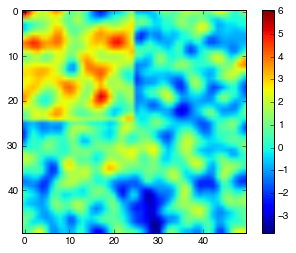

In [6]:
plt.figure(figsize=(6,4))
plt.imshow(data[0:50,0:50,1])
plt.colorbar()
plt.show()

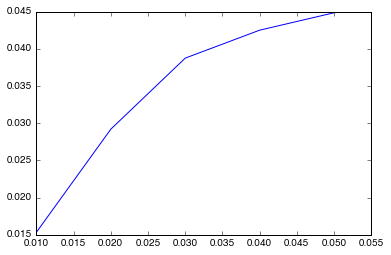

In [5]:
means = []
for alpha in thres:
    means.append(np.nanmean(res[alpha]))
    
plt.figure(figsize=(6,4))
plt.plot(thres,means)